In [1]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte

%matplotlib inline

# Getting the images compressed file from Google Drive and extracting

In [ ]:
!pip install gdown

In [ ]:
!gdown -O ../../datasets/ebay_boys_girls_shirts.tar.gz "https://drive.google.com/uc?id=14SgVvj6k12yXDJ82Qz4TdnqaaOBFjZj0"

In [ ]:
import tarfile
with tarfile.open('../../datasets/ebay_boys_girls_shirts.tar.gz', "r:gz") as tar:
    tar.extractall('../../datasets/')

# Once the images are extracted in `datasets` folder

In [2]:
def check_mem():
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    print(sorted([(x, sys.getsizeof(globals().get(x))) for x in globals() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

def get_file_list(df, folder, n_sample = None, seed = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample, random_state = seed).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    img = transform.resize(img, (w, h), mode='constant', anti_aliasing=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = img_as_ubyte(img)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

def get_images_matrix(csv_file, folder, n = None, seed = 1976):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n, seed)
    images = read_images_4d_array(files_list)
    return images

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

In [3]:
folder = '../../datasets/ebay_boys_girls_shirts/'
boys_train_df = pd.read_csv(folder + 'boys_train.csv')
girls_train_df = pd.read_csv(folder + 'girls_train.csv')

In [4]:
boys_display_files = get_file_list(boys_train_df, folder + 'boys', 400)
girls_display_files = get_file_list(girls_train_df, folder + 'girls', 400)
print(boys_display_files[:5])

['../../datasets/ebay_boys_girls_shirts/boys/14088.jpg', '../../datasets/ebay_boys_girls_shirts/boys/3900.jpg', '../../datasets/ebay_boys_girls_shirts/boys/7117.jpg', '../../datasets/ebay_boys_girls_shirts/boys/3181.jpg', '../../datasets/ebay_boys_girls_shirts/boys/4960.jpg']


In [5]:
boys_display_images = read_images_4d_array(boys_display_files)
girls_display_images = read_images_4d_array(girls_display_files)
print(boys_display_images.shape)
print(boys_display_images[0].dtype)

(400, 100, 100, 3)
uint8


## Displaying Grid of Random 400 Images

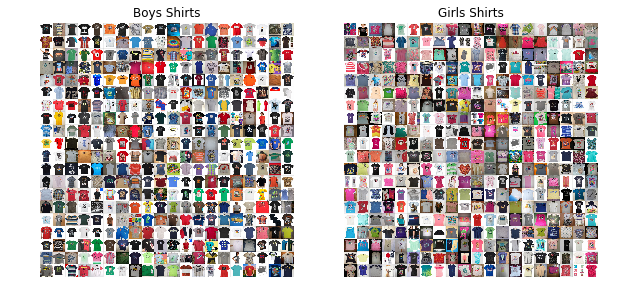

In [6]:
def merge_images(image_batch, size = [20, 20]):
    h,w = image_batch.shape[1], image_batch.shape[2]
    c = image_batch.shape[3]
    img = np.zeros((int(h*size[0]), w*size[1], c))
    for idx, im in enumerate(image_batch):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w,:] = im/255 #notice we divide by 255 to get 0-1 float range
    return img

boys_merged = merge_images(boys_display_images)
girls_merged = merge_images(girls_display_images)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Boys Shirts')
plt.axis('off')
plt.imshow(boys_merged)

plt.subplot(1, 2, 2)
plt.title('Girls Shirts')
plt.axis('off')
plt.imshow(girls_merged)

Definitely much more pink in girls shirts, much more blue in boys shirts, I'd say equal number of red.

## Color Histograms

In [7]:
def plot_hist_normed(images, channel, col):
    vals = images[:, :, :, channel].flatten()
    plt.hist(vals, weights = np.ones_like(vals) / len(vals), color = col)
    plt.ylim([0, 0.3])
    plt.yticks([])

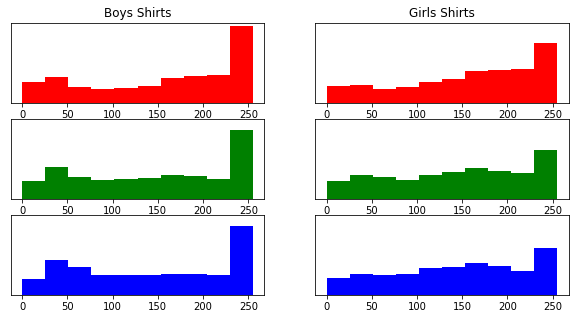

In [8]:
plt.figure(figsize =(10, 5))
plt.subplot(3, 2, 1)
plot_hist_normed(boys_display_images, 0, 'red')
plt.title('Boys Shirts')
plt.subplot(3, 2, 2)
plot_hist_normed(girls_display_images, 0, 'red')
plt.title('Girls Shirts')
plt.subplot(3, 2, 3)
plot_hist_normed(boys_display_images, 1, 'green')
plt.subplot(3, 2, 4)
plot_hist_normed(girls_display_images, 1, 'green')
plt.subplot(3, 2, 5)
plot_hist_normed(boys_display_images, 2, 'blue')
plt.subplot(3, 2, 6)
plot_hist_normed(girls_display_images, 2, 'blue')
plt.show()

In [9]:
def summary(images, channel, col):
    vals = (images[:, :, :, channel]/255).flatten()
    print('  %s mean: %.2f, median: %.2f, share above 0.9: %.2f' %(col, np.mean(vals), np.median(vals), np.mean(vals > 0.9)))
print('Boys:')
summary(boys_display_images, 0, 'red')
summary(boys_display_images, 1, 'green')
summary(boys_display_images, 2, 'blue')
print('Girls:')
summary(girls_display_images, 0, 'red')
summary(girls_display_images, 1, 'green')
summary(girls_display_images, 2, 'blue')

Boys:
  red mean: 0.62, median: 0.70, share above 0.9: 0.29
  green mean: 0.58, median: 0.60, share above 0.9: 0.26
  blue mean: 0.57, median: 0.58, share above 0.9: 0.26
Girls:
  red mean: 0.63, median: 0.68, share above 0.9: 0.22
  green mean: 0.57, median: 0.60, share above 0.9: 0.18
  blue mean: 0.57, median: 0.59, share above 0.9: 0.18


Girls and boys shirts have more or less the same level of color, whatever channel we look, mean or median.

However, boys shirts have more pixels with extreme red, blue or green values.

## Load 10% of data

In [11]:
x_boys_train = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', 1000)
x_boys_test = get_images_matrix(folder + 'boys_test.csv', folder + 'boys', 250)
x_girls_train = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', 1000)
x_girls_test = get_images_matrix(folder + 'girls_test.csv', folder + 'girls', 250)

y_boys_train = np.array([0] * x_boys_train.shape[0])
y_boys_test = np.array([0] * x_boys_test.shape[0])
y_girls_train = np.array([1] * x_girls_train.shape[0])
y_girls_test = np.array([1] * x_girls_test.shape[0])

## Single Predictor, Average Pixel

For each image get overall average pixel, and average for each of 3 channels:

In [12]:
def get_average_pixels(x):
    return np.hstack([x.mean(axis = (1, 2, 3)).reshape((-1, 1)), x.mean(axis = (1, 2))])
x_boys_train_av = get_average_pixels(x_boys_train)
x_boys_test_av = get_average_pixels(x_boys_test)
x_girls_train_av = get_average_pixels(x_girls_train)
x_girls_test_av = get_average_pixels(x_girls_test)

x_train = np.vstack([x_boys_train_av, x_girls_train_av])
x_test = np.vstack([x_boys_test_av, x_girls_test_av])
y_train = np.concatenate([y_boys_train, y_girls_train])
y_test = np.concatenate([y_boys_test, y_girls_test])

### Logistic Regression:

In [13]:
from sklearn.linear_model import LogisticRegression

def lr(dim, dim_name):
    mod = LogisticRegression(solver='lbfgs')
    mod.fit(x_train[:, dim].reshape(-1, 1), y_train)
    acc = mod.score(x_test[:, dim].reshape(-1, 1), y_test)
    print('Accuracy of %s channel: %.2f' % (dim_name, acc))

lr(0, 'all')
lr(1, 'red')
lr(2, 'green')
lr(3, 'blue')

Accuracy of all channel: 0.53
Accuracy of red channel: 0.52
Accuracy of green channel: 0.52
Accuracy of blue channel: 0.50


Incredibly bad.

### Classification Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

def tr(dim, dim_name):
    mod = DecisionTreeClassifier()
    mod.fit(x_train[:, dim].reshape(-1, 1), y_train)
    acc = mod.score(x_test[:, dim].reshape(-1, 1), y_test)
    print('Accuracy of %s channel: %.2f' % (dim_name, acc))

tr(0, 'all')
tr(1, 'red')
tr(2, 'green')
tr(3, 'blue')

Accuracy of all channel: 0.51
Accuracy of red channel: 0.52
Accuracy of green channel: 0.50
Accuracy of blue channel: 0.52


Same.

## Multiple Predictors, Average Pixel

### Logistic Regression

In [15]:
mod = LogisticRegression(solver='lbfgs')
mod.fit(x_train[:, 1:], y_train)
acc = mod.score(x_test[:, 1:], y_test)
print('Accuracy of LR on all channels: %.2f' % acc)
coef_names = ['red', 'green', 'blue']
coef = mod.coef_[0]
print('log-odds: %.2f + %.2f * %s + %.2f * %s + %.2f * %s' %
      (mod.intercept_, coef[0], coef_names[0], coef[1], coef_names[1], coef[2], coef_names[2]))

Accuracy of LR on all channels: 0.56
log-odds: -0.60 + 0.01 * red + -0.01 * green + 0.00 * blue


Slightly better.

### Classification Tree

In [16]:
mod = DecisionTreeClassifier()
mod.fit(x_train[:, 1:], y_train)
acc = mod.score(x_test[:, 1:], y_test)
print('Accuracy of CART on all channels: %.2f' % acc)

Accuracy of CART on all channels: 0.53


Trying to print the tree by copy-pasting [this](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html):

In [17]:
# Using those arrays, we can parse the tree structure:

n_nodes = mod.tree_.node_count
children_left = mod.tree_.children_left
children_right = mod.tree_.children_right
feature = mod.tree_.feature
threshold = mod.tree_.threshold


# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print("The binary tree structure has %s nodes and has "
      "the following tree structure:"
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
    else:
        print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
              "node %s."
              % (node_depth[i] * "\t",
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

The binary tree structure has 1159 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 0] <= 234.326202393 else to node 1098.
	node=1 test node: go to node 2 if X[:, 0] <= 142.948204041 else to node 441.
		node=2 test node: go to node 3 if X[:, 2] <= 115.093151093 else to node 236.
			node=3 test node: go to node 4 if X[:, 0] <= 77.6725502014 else to node 39.
				node=4 test node: go to node 5 if X[:, 0] <= 40.4448509216 else to node 6.
					node=5 leaf node.
					node=6 test node: go to node 7 if X[:, 1] <= 96.8804473877 else to node 36.
						node=7 test node: go to node 8 if X[:, 2] <= 36.555398941 else to node 9.
							node=8 leaf node.
							node=9 test node: go to node 10 if X[:, 2] <= 38.4354000092 else to node 11.
								node=10 leaf node.
								node=11 test node: go to node 12 if X[:, 1] <= 49.3848018646 else to node 15.
									node=12 test node: go to node 13 if X[:, 1] <= 43.5684013367 else to node 14.
										node=13 leaf node.
						